# Forest Cover Type Prediction

https://www.kaggle.com/c/forest-cover-type-prediction

## Author

* Divya Gorantla
* Ram Iyer
* Tiffany Jaya
* Steve Sanders

## Problem

Predict the forest cover type (the predominant kind of tree cover) from stricly cartographic varaibles (as opposed to remotely sensed data). 

## Data Description

The study area includes four wilderness areas located in the Roosevelt National Forest of northern Colorado. Each observation is a 30m x 30m patch. You are asked to predict an integer classification for the forest cover type. The seven types are:

```
1 - Spruce/Fir 
2 - Lodgepole Pine 
3 - Ponderosa Pine 
4 - Cottonwood/Willow 
5 - Aspen
6 - Douglas-fir
7 - Krummholz
```

The training set (15120 observations) contains both features and the Cover_Type. The test set contains only the features. You must predict the Cover_Type for every row in the test set (565892 observations).

```
Data Fields
Elevation - Elevation in meters
Aspect - Aspect in degrees azimuth
Slope - Slope in degrees
Horizontal_Distance_To_Hydrology - Horz Dist to nearest surface water features
Vertical_Distance_To_Hydrology - Vert Dist to nearest surface water features
Horizontal_Distance_To_Roadways - Horz Dist to nearest roadway
Hillshade_9am (0 to 255 index) - Hillshade index at 9am, summer solstice
Hillshade_Noon (0 to 255 index) - Hillshade index at noon, summer solstice
Hillshade_3pm (0 to 255 index) - Hillshade index at 3pm, summer solstice
Horizontal_Distance_To_Fire_Points - Horz Dist to nearest wildfire ignition points
Wilderness_Area (4 binary columns, 0 = absence or 1 = presence) - Wilderness area designation
Soil_Type (40 binary columns, 0 = absence or 1 = presence) - Soil Type designation
Cover_Type (7 types, integers 1 to 7) - Forest Cover Type designation
```

The wilderness areas are:

```
1 - Rawah Wilderness Area
2 - Neota Wilderness Area
3 - Comanche Peak Wilderness Area
4 - Cache la Poudre Wilderness Area
```

The soil types are:

```
1 Cathedral family - Rock outcrop complex, extremely stony.
2 Vanet - Ratake families complex, very stony.
3 Haploborolis - Rock outcrop complex, rubbly.
4 Ratake family - Rock outcrop complex, rubbly.
5 Vanet family - Rock outcrop complex complex, rubbly.
6 Vanet - Wetmore families - Rock outcrop complex, stony.
7 Gothic family.
8 Supervisor - Limber families complex.
9 Troutville family, very stony.
10 Bullwark - Catamount families - Rock outcrop complex, rubbly.
11 Bullwark - Catamount families - Rock land complex, rubbly.
12 Legault family - Rock land complex, stony.
13 Catamount family - Rock land - Bullwark family complex, rubbly.
14 Pachic Argiborolis - Aquolis complex.
15 unspecified in the USFS Soil and ELU Survey.
16 Cryaquolis - Cryoborolis complex.
17 Gateview family - Cryaquolis complex.
18 Rogert family, very stony.
19 Typic Cryaquolis - Borohemists complex.
20 Typic Cryaquepts - Typic Cryaquolls complex.
21 Typic Cryaquolls - Leighcan family, till substratum complex.
22 Leighcan family, till substratum, extremely bouldery.
23 Leighcan family, till substratum - Typic Cryaquolls complex.
24 Leighcan family, extremely stony.
25 Leighcan family, warm, extremely stony.
26 Granile - Catamount families complex, very stony.
27 Leighcan family, warm - Rock outcrop complex, extremely stony.
28 Leighcan family - Rock outcrop complex, extremely stony.
29 Como - Legault families complex, extremely stony.
30 Como family - Rock land - Legault family complex, extremely stony.
31 Leighcan - Catamount families complex, extremely stony.
32 Catamount family - Rock outcrop - Leighcan family complex, extremely stony.
33 Leighcan - Catamount families - Rock outcrop complex, extremely stony.
34 Cryorthents - Rock land complex, extremely stony.
35 Cryumbrepts - Rock outcrop - Cryaquepts complex.
36 Bross family - Rock land - Cryumbrepts complex, extremely stony.
37 Rock outcrop - Cryumbrepts - Cryorthents complex, extremely stony.
38 Leighcan - Moran families - Cryaquolls complex, extremely stony.
39 Moran family - Cryorthents - Leighcan family complex, extremely stony.
40 Moran family - Cryorthents - Rock land complex, extremely stony.
```

## Libraries

In [1]:
# output plots within notebook
%matplotlib inline

# install the kaggle library
!pip install kaggle

# install libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

# set seed for reproducibility
tf.set_random_seed(6)

You are using pip version 9.0.1, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


/Users/tiffapedia/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Load Data

In order to use Kaggle API:
1. Login to your Kaggle account
2. Select 'My account'
3. Select 'Create New API Token'
4. Place the token 'kaggle.json' into ~/.kaggle

In [2]:
# download each ZIP file from Kaggle
!kaggle competitions download -c forest-cover-type-prediction -p ./data 

train.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
sampleSubmission.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
test.csv.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
TRAIN_FILENAME = 'train.csv'
TEST_FILENAME = 'test.csv'
SAMPLE_SUBMISSION_FILENAME = 'sampleSubmission.csv'
DATAPATH = './data/'

def get_data(filename, unzip=False):
    '''Read CSV file (unzip or not) into a dataframe'''
    if unzip:
        zippath = DATAPATH + filename + '.zip'
        return pd.read_csv(zippath, compression='zip', header=0, sep=',', quotechar='"')
    
    filepath = DATAPATH + filename
    return pd.read_csv(filepath, header=0, sep=',', quotechar='"')
    
train = get_data(TRAIN_FILENAME, unzip=True)
test = get_data(TEST_FILENAME, unzip=True)
sample = get_data(SAMPLE_SUBMISSION_FILENAME, unzip=True)

In [4]:
train_label = train['Cover_Type']

## EDA

In [5]:
print('-' * 80)
print('{:>40}'.format('EDA'))
print('-' * 80)
columns = ['shape', 'types']
rows = ['train', 'test', 'sample']
print(pd.DataFrame({columns[0]: [train.shape, test.shape, sample.shape],
                    columns[1]: [pd.unique(train.dtypes), pd.unique(test.dtypes), pd.unique(sample.dtypes)]},
                   columns=columns,
                   index=rows))
print('-' * 80)
print('{:>50}'.format('Describe Dataset: train'))
print('-' * 80)
print(train.describe())


--------------------------------------------------------------------------------
                                     EDA
--------------------------------------------------------------------------------
               shape    types
train    (15120, 56)  [int64]
test    (565892, 55)  [int64]
sample   (565892, 2)  [int64]
--------------------------------------------------------------------------------
                           Describe Dataset: train
--------------------------------------------------------------------------------
                Id     Elevation        Aspect         Slope  \
count  15120.00000  15120.000000  15120.000000  15120.000000   
mean    7560.50000   2749.322553    156.676653     16.501587   
std     4364.91237    417.678187    110.085801      8.453927   
min        1.00000   1863.000000      0.000000      0.000000   
25%     3780.75000   2376.000000     65.000000     10.000000   
50%     7560.50000   2752.000000    126.000000     15.000000   
75%    11340.250

/Users/tiffapedia/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


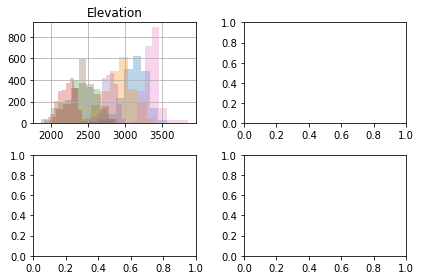

In [41]:
# plot histogram of each column (aka feature)

# 1. plot without overlay
#for column in train.columns[1:11]: 
#    train.groupby('Cover_Type').hist(column=column, alpha=0.3)

# 2. plot with overlay
nrows = 2
ncols = 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols)
ax_ct, ax_1, ax_2, ax_3 = axes.flatten() 

for label, data in train.groupby('Cover_Type')['Elevation']:
    data.hist(alpha=0.3, ax=ax_ct)
ax_ct.set_title('Elevation')
ax_ct.legend()

fig.tight_layout()
plt.show()

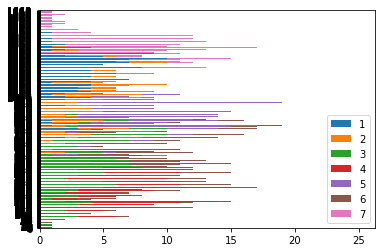

In [157]:
# visualize elevation by cover types
# 1. count the number of cover types per elevation
plt_ct_per_el = pd.DataFrame(pd.crosstab(train['Elevation'], train['Cover_Type']).values.tolist(),
                             columns=sorted(pd.unique(train['Cover_Type'])))
# 2. plot the associating horizontal, stacked graph
plt_ct_per_el.plot.barh(stacked=True);

From the graph shown above, it appears that the cover types most commonly found at the high altitude is Krummholz followed by the following cover types found in descending order of altitudes: 

```
7 - Krummholz
1 - Spruce/Fir 
2 - Lodgepole Pine
5 - Aspen
3 - Ponderosa Pine 
6 - Douglas-fir
4 - Cottonwood/Willow 
```

## Model 

### Logistic Regression